# Executive Summary
This report presents an analysis of the cell tower data for Africa, with a focus on identifying anomalous or unusual cell tower data using a combination of the Isolation Forest algorithm and time-based anomaly detection techniques.

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.ensemble import IsolationForest

In [2]:
df = pd.read_csv("Africa towers.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2346316 entries, 0 to 2346315
Data columns (total 18 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Unnamed: 0     int64  
 1   radio          object 
 2   MCC            int64  
 3   MNC            int64  
 4   TAC            int64  
 5   CID            int64  
 6   unit           int64  
 7   LON            float64
 8   LAT            float64
 9   RANGE          int64  
 10  SAM            int64  
 11  changeable     int64  
 12  created        int64  
 13  updated        int64  
 14  averageSignal  int64  
 15  Country        object 
 16  Network        object 
 17  Continent      object 
dtypes: float64(2), int64(12), object(4)
memory usage: 322.2+ MB


In [4]:
df.rename(columns = {'TAC': 'LAC'}, inplace= True)

In [5]:
df['radio'] = df['radio'].astype('category')

In [6]:
# Checking of null values
df.isna().values.any()

False

There are no null values in the dataset.

In [7]:
# Checking for duplicated values
df.duplicated().values.any()

False

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2346316 entries, 0 to 2346315
Data columns (total 18 columns):
 #   Column         Dtype   
---  ------         -----   
 0   Unnamed: 0     int64   
 1   radio          category
 2   MCC            int64   
 3   MNC            int64   
 4   LAC            int64   
 5   CID            int64   
 6   unit           int64   
 7   LON            float64 
 8   LAT            float64 
 9   RANGE          int64   
 10  SAM            int64   
 11  changeable     int64   
 12  created        int64   
 13  updated        int64   
 14  averageSignal  int64   
 15  Country        object  
 16  Network        object  
 17  Continent      object  
dtypes: category(1), float64(2), int64(12), object(3)
memory usage: 306.6+ MB


# Partial Conclusion: 
Since there are no null or duplicate values in the dataset, hence, the data is clean.

 # Exploratory Data Analysis
 Here we analyse the different features in the dataset.

Text(0.5, 1.0, 'Number of Cell Towers by Radio Technologies')

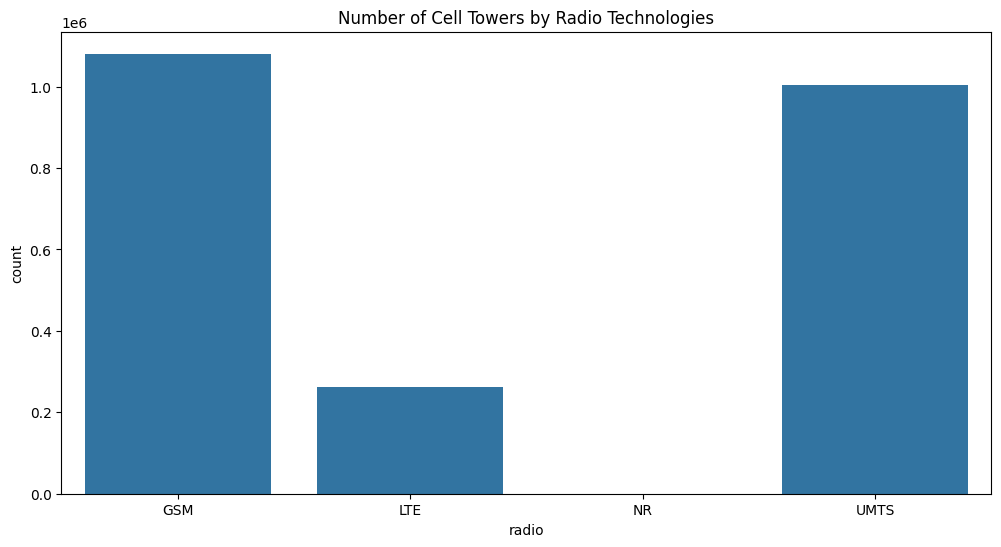

In [9]:
plt.figure(figsize=(12,6))
sns.countplot(data = df, x= 'radio')
plt.title('Number of Cell Towers by Radio Technologies')

In Africa, we observe a greater adoption of GSM radio technologies compared to other cellular standards. This is followed by UMTS, then LTE and finally NR (New Radio) technologies.

Text(0.5, 1.0, "Diversity of Radio Access Technologies in Africa's Telecommunication Networks")

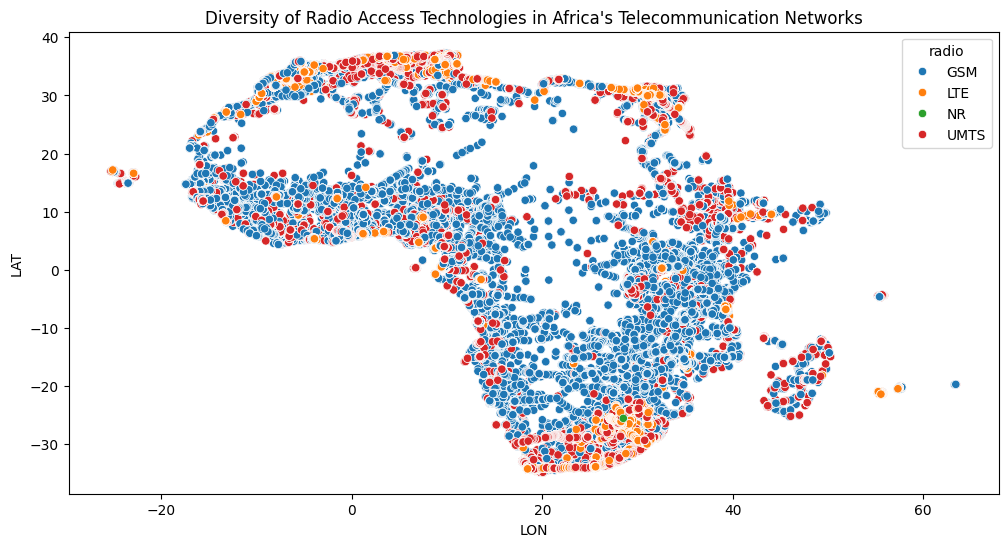

In [10]:
# Looking at the relationship between the Latitude and Longitude alongside the distribution of the radio technologies
plt.figure(figsize=(12,6))
sns.scatterplot(data = df , x ='LON',y = 'LAT', hue = 'radio')
plt.title("Diversity of Radio Access Technologies in Africa's Telecommunication Networks")

The scatter plot of latitude and longitude coordinate accurately represents the geographical shape and boundaries of the African continent as well as how the different radio technologies are distributed across the continent. Furthermore, we can rarely see the adoption of New Radio technology (5G) which only goes to mean that, very few African countries have adopted this technology so far.
Moreso, the scattered nature of the dots distribution  could likely be caused by factors like terrain and economic development that likely play a role in the uneven rollout of technologies.

Text(0.5, 1.0, 'African Countries That Have Adopted New Radio (5G) Technologies')

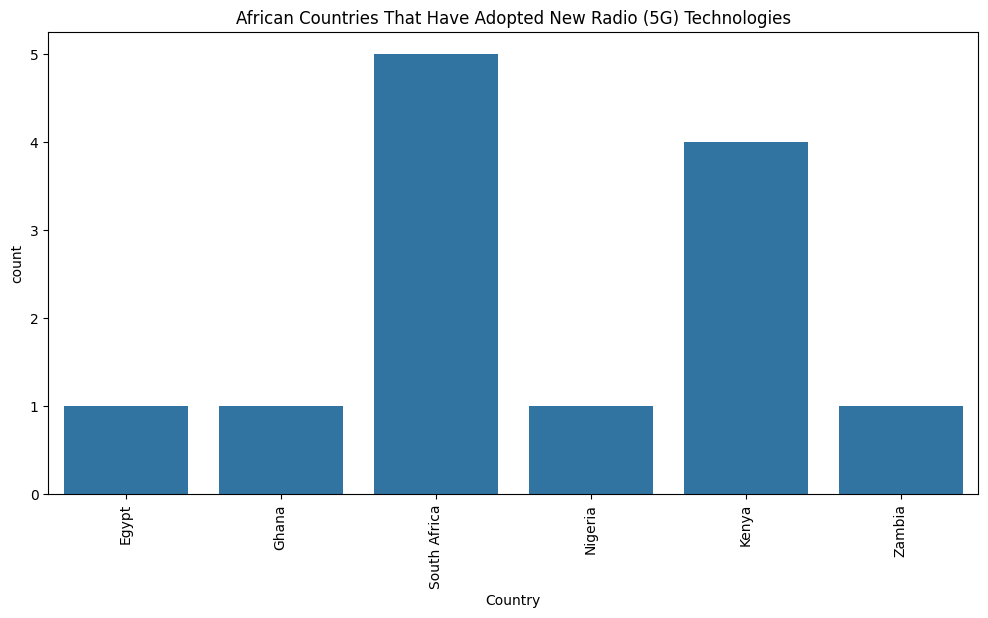

In [11]:
plt.figure(figsize=(12,6))
NR = df[df['radio'] == 'NR']
sns.countplot(data = NR, x='Country')
plt.xticks(rotation = 90)
plt.title("African Countries That Have Adopted New Radio (5G) Technologies")

We observed that about 6 countries have adopted New Radio (5G) technologies so far, with South Africa leading in the number of cell towers antennas, followed by Kenya.

In [12]:
NR['Country'].value_counts()

Country
South Africa    5
Kenya           4
Egypt           1
Ghana           1
Nigeria         1
Zambia          1
Name: count, dtype: int64

Text(0.5, 1.0, 'Number of Cell Towers by Countries')

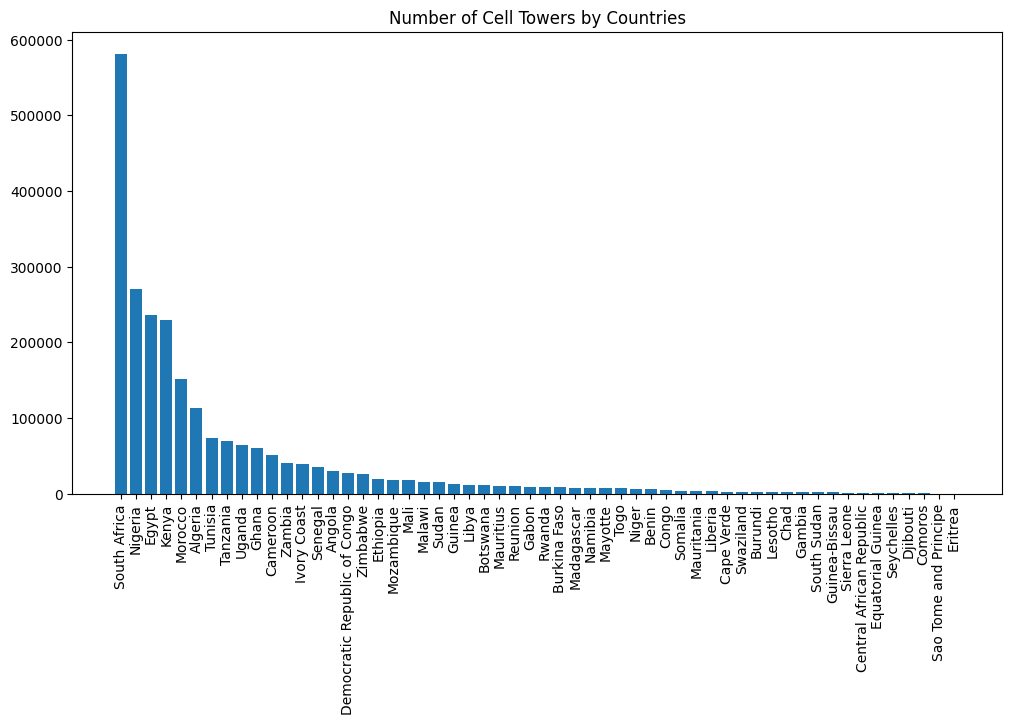

In [13]:
countries = df.Country.value_counts()
plt.figure(figsize=(12,6))
plt.bar(countries.index, countries.values)
plt.xticks(rotation = 90)
plt.title("Number of Cell Towers by Countries")

South Africa has a higher number of cell towers compared to other countries in Africa.

In [14]:
network = df.Network.value_counts()

Text(0.5, 1.0, 'Number of Cell Towers by Company')

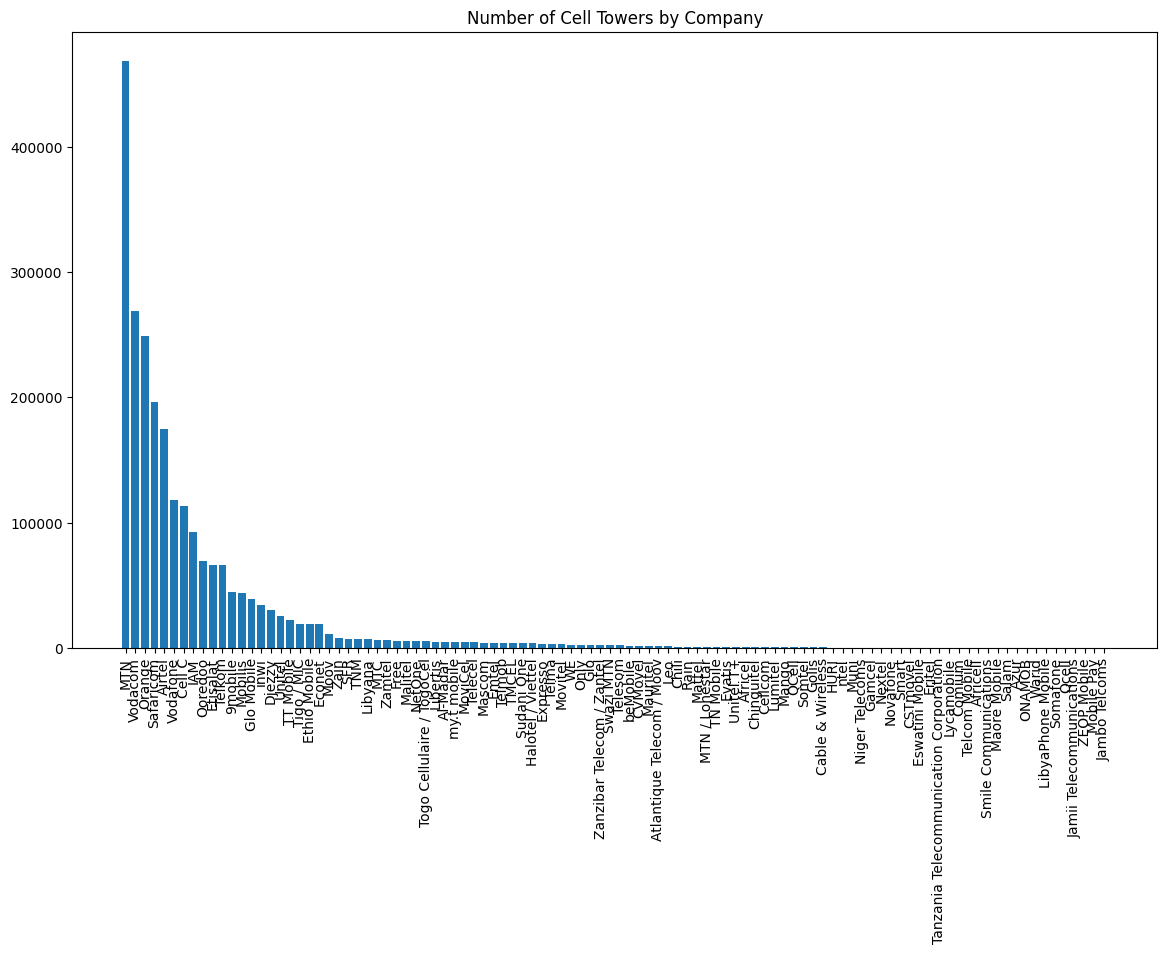

In [15]:
plt.figure(figsize=(14,8))
plt.bar(network.index, network.values)
plt.xticks(rotation = 90)
plt.title("Number of Cell Towers by Company")

From the above bar chart we can deduce that, there are more MTN cellular networks in Africa, followed by Vodacom then Orange etc.

# Detecting Anomalies

**1. Time Based Detection of Cell Towers Anomalies**

In [16]:
df['created'] = pd.to_datetime(df['created'], unit ='s')

In [17]:
data = df.set_index('created')

In [18]:
mean= data.resample('ME').size().mean()
std_dev = data.resample('ME').size().std()
lower_threshold = mean - (3 * std_dev)
upper_threshold = mean + (3 * std_dev)
anomalies = data.resample('ME').size()[(data.resample('ME').size() < lower_threshold)| (data.resample('ME').size() > upper_threshold)]

Text(0, 0.5, 'Number of Cell Towers')

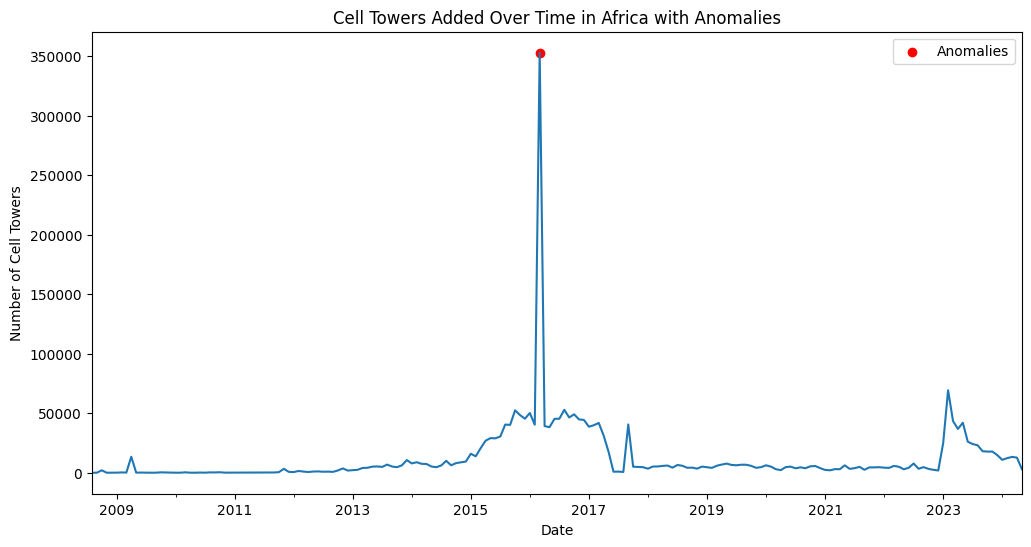

In [19]:
fig, ax = plt.subplots(figsize =(12,6))
data.resample('ME').size().plot(ax=ax)
ax.scatter(anomalies.index,[data.resample('ME').size()[i] for i in anomalies.index], color ='red', label = 'Anomalies')
ax.legend()
ax.set_title('Cell Towers Added Over Time in Africa with Anomalies')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Cell Towers')

In [20]:
print(anomalies)

created
2016-03-31    353041
Freq: ME, dtype: int64


**Conclusion :**
There was a sudden and substantial change around 2016-03-31 in the rate of tower additions which could be likely due to extraordinary events or factors that have must have influenced this outcome.

**2. Using Isolation Forest**

Here I used Isolation Forest to detect anomalies

In [21]:
X = data.resample('ME').size().to_frame('cell_towers')

In [22]:
clf = IsolationForest(contamination=0.01)
y_pred = clf.fit_predict(X)
anomal = X[y_pred == -1]
print("Detected Anomalities")
print(anomal)

Detected Anomalities
            cell_towers
created                
2016-03-31       353041
2023-02-28        69300


**Conclusion**

Our model seems to have identified the spike at 2023-02-28 as an anomalie as well which wasn't detected in our initial analysis as the thresholds were set to three standard deviations away from the mean.